In [24]:
import os
import torch
import numpy as np
import argparse
import scipy.io
from matplotlib import pyplot as plt
import matplotlib
from matplotlib import cm

In [4]:
def load_data(path, keys=None):
    if keys is None:
        # default: 2D
        keys = ['x', 'tt', 'uu']
    data = scipy.io.loadmat(path)
    xi = [np.real(data[k]).reshape((-1, 1)) for k in keys[:-1]]
    raw = np.real(data[keys[-1]]).T
    u = np.real(data[keys[-1]]).T.reshape((-1, 1))
    x = np.concatenate([xx.reshape((-1, 1)) for xx in np.meshgrid(*xi)], axis=1)
    data = np.concatenate([x, u], axis=1)
    domain = [[np.min(x[:, i]), np.max(x[:, i])] for i in range(x.shape[-1])]
    return data, domain, raw

def load_pred_data(path, keys=None):
    if keys is None:
        keys = ['x', 'gt', 'pred']
    data = scipy.io.loadmat(path)
    return np.real(data[keys[0]]), np.real(data[keys[1]]), np.real(data[keys[2]])

In [5]:
ground_truth_path = "burgers.mat"
data, domain, raw = load_data(ground_truth_path)

prediction_path = "burgers_pre.mat"
X_u, ground_truth, pred = load_pred_data(prediction_path)

In [11]:
data

array([[-1.00000000e+00,  0.00000000e+00,  1.22464680e-16],
       [-9.92156863e-01,  0.00000000e+00,  2.46374492e-02],
       [-9.84313725e-01,  0.00000000e+00,  4.92599411e-02],
       ...,
       [ 9.84313725e-01,  9.90000000e-01, -1.19673204e-02],
       [ 9.92156863e-01,  9.90000000e-01, -5.98368729e-03],
       [ 1.00000000e+00,  9.90000000e-01,  1.12388795e-16]])

In [12]:
X_u = data[:,:-1]

In [17]:
u = ground_truth.T
pred = pred.T
path = '.'
domain = domain

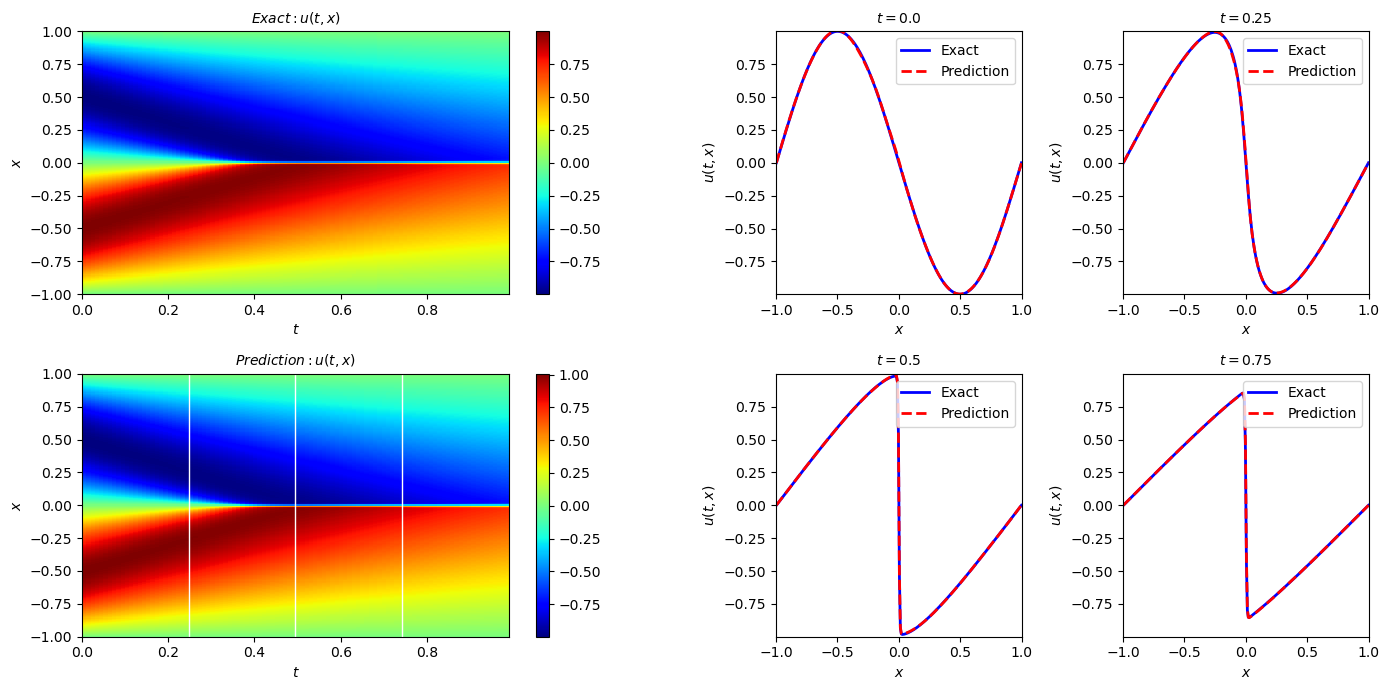

In [29]:
plt.figure(figsize=(14, 7))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

plt.subplot(2, 2, 1)
plt.imshow(u, interpolation='nearest', cmap=cm.jet,
               extent=list(domain[1]) + list(domain[0]), origin='lower', aspect='auto')
plt.colorbar()

plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('$Exact: u(t,x)$', fontsize=10)

plt.subplot(2, 2, 3)
plt.imshow(pred, interpolation='nearest', cmap=cm.jet,
            extent=list(domain[1]) + list(domain[0]), origin='lower', aspect='auto')
plt.colorbar()

xmin, xmax = domain[0]
line = np.linspace(xmin, xmax, 2)[:, None]
ymin, ymax = domain[1]
plt.plot((0.25 * (ymax - ymin) + ymin) * np.ones((2, 1)), line, 'w-', linewidth=1)
plt.plot((0.5 * (ymax - ymin) + ymin) * np.ones((2, 1)), line, 'w-', linewidth=1)
plt.plot((0.75 * (ymax - ymin) + ymin) * np.ones((2, 1)), line, 'w-', linewidth=1)
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('$Prediction: u(t,x)$', fontsize=10)

delta = 1.0 / u.shape[0]
x = np.array([(i + 0.5) * delta for i in range(u.shape[0])]) * (xmax - xmin) + xmin
pos = [3, 4, 7, 8]

for i in range(4):
    plt.subplot(2, 4, pos[i])
    plt.plot(x, u[:, int(i / 4 * u.shape[1])], 'b-', linewidth=2, label='Exact')
    plt.plot(x, pred[:, int(i / 4 * u.shape[1])], 'r--', linewidth=2, label='Prediction')
    plt.xlabel('$x$')
    plt.ylabel('$u(t,x)$')
    plt.title('$t = {}$'.format(round(i / 4, 2)), fontsize=10)
    plt.xlim([xmin, xmax])
    plt.ylim([u.min(), u.max()])
    plt.legend(loc='upper right')

plt.tight_layout()
if path is not None:
    plt.savefig(os.path.join(path, 'viz.jpg'))
plt.show()


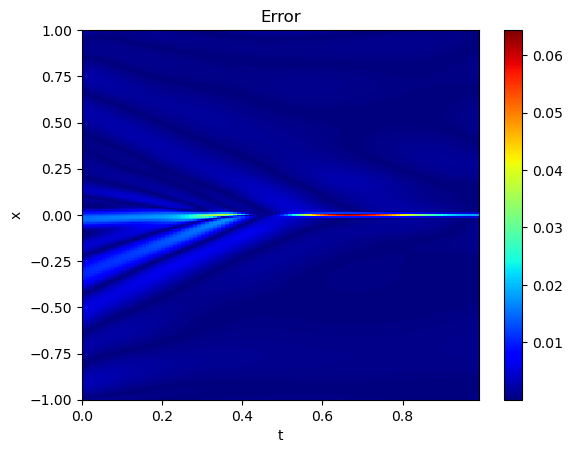

In [28]:
plt.figure()
pinn_error = abs(u-pred)
plt.imshow(pinn_error, interpolation='nearest', cmap=cm.jet,
               extent=list(domain[1]) + list(domain[0]), origin='lower', aspect='auto')
plt.xlabel('t')
plt.ylabel('x')
plt.title('Error')
plt.colorbar()
plt.savefig(os.path.join(path, 'error.jpg'))
plt.show()

In [20]:
N_0 = 100
N_b = 100
N_r = 10_000
N_u = 2000

tmin,tmax=0. ,1.
xmin,xmax = -1.,1.

# U[0,x] = -sin(pi*x)
t_0 = np.ones([N_0,1],dtype='float32')*0.
x_0 = np.random.uniform(low=xmin,high=xmax,size=(N_0,1))
ic_0 = -np.sin(np.pi*x_0) 
IC_0 = np.concatenate([t_0,x_0,ic_0],axis=1)

# U[t,-1] = 0
t_b1 = np.random.uniform(low=tmin,high=tmax,size=(N_b,1))
x_b1 = np.ones_like(t_b1) *-1
bc_1 = np.zeros_like(t_b1)
BC_1 = np.concatenate([t_b1,x_b1,bc_1],axis=1)

# U[t,1] = 0
t_b2 = np.random.uniform(low=tmin,high=tmax,size=(N_b,1))
x_b2 = np.ones_like(t_b2) 
bc_2 = np.zeros_like(t_b2)
BC_2 = np.concatenate([t_b2,x_b2,bc_2],axis=1)

conds = [IC_0,BC_1,BC_2]

#collocation points
t_c = np.random.uniform(low=tmin,high=tmax,size=(N_r,1))
x_c = np.random.uniform(low=xmin,high=xmax,size=(N_r,1))
colloc = np.concatenate([t_c,x_c],axis=1) 


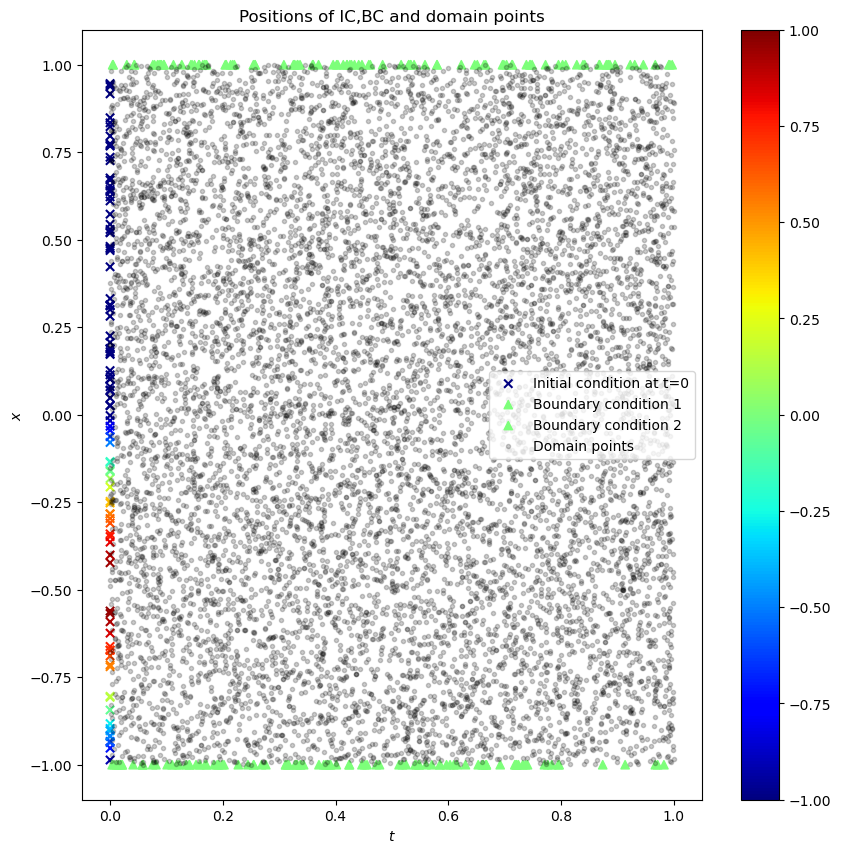

In [62]:
fig = plt.figure(figsize=(10,10))
plt.scatter(t_0, x_0, c=ic_0, marker='x', vmin=0, vmax=1,label='Initial condition at t=0',cmap=matplotlib.cm.jet)
plt.scatter(t_b1, x_b1, c=bc_1, marker='^', vmin=-1, vmax=1,label='Boundary condition 1',cmap=matplotlib.cm.jet)
plt.scatter(t_b2, x_b2, c=bc_2, marker='^', vmin=-1, vmax=1,label='Boundary condition 2',cmap=matplotlib.cm.jet)


cmap = cm.jet
norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)


plt.scatter(t_c, x_c, c='k', marker='.', alpha=0.2,label='Domain points',cmap=cm.jet)
plt.xlabel('$t$')
plt.ylabel('$x$')

plt.title('Positions of IC,BC and domain points');
plt.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap))
plt.legend(loc='center right')
plt.savefig(os.path.join(path, 'train.jpg'))

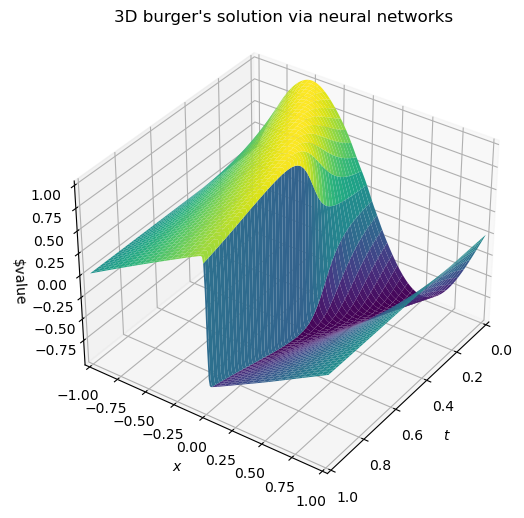

In [63]:
X = data[:,0].reshape((100, 256))
T = data[:,1].reshape((100, 256))
U = pred.T

fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(T, X, U[:],  cmap=cm.viridis)
ax.set_xlim(tmin, tmax)
ax.set_ylim(xmin, xmax)
ax.view_init(35,35)
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_zlabel('$value')
ax.set_title("3D burger's solution via neural networks")
plt.savefig(os.path.join(path, '3D_value.jpg'))

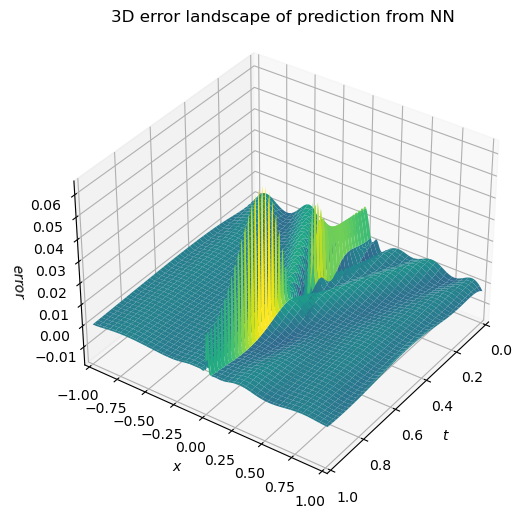

In [64]:
X = data[:,0].reshape((100, 256))
T = data[:,1].reshape((100, 256))
U = pred.T - ground_truth

fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')
ax.set_title("3D error landscape of prediction from NN")
ax.plot_surface(T, X, U[:],  cmap=cm.viridis)
ax.set_xlim(tmin, tmax)
ax.set_ylim(xmin, xmax)
ax.view_init(35,35)
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_zlabel('$error$')
plt.savefig(os.path.join(path, '3D_error.jpg'))